# Parámetros globales del *Notebook*

In [64]:
# Para definir los path
import os

# Define si estamos ejecutando el Notebook en nuestro 
# ordenador ("local") o en Google Colab ("remote")
RUNNING_ENV = "local"

# Path que vamos a usar como base para el resto de paths
BASE_PATH = "./" if RUNNING_ENV == "local" else "/content/drive/MyDrive/Colab Notebooks/"

# Directorio en el que guardamos los scripts de python que usamos 
# como libreria propia
LIB_PATH = os.path.join(BASE_PATH, "lib")

# Directorio en el que guardamos los datos de entrenamiento y test
DATA_PATH = os.path.join(BASE_PATH, "data")

# Numero de procesos que queremos usar
NUM_WORKERS = 2

# Batch size que queremos usar para los dataloaders que usamos
DATALOADER_BACH_SIZE = 32

# Autorización si estamos usando Google Drive

In [65]:
if RUNNING_ENV == "remote":
    from google.colab import drive
    drive.mount('/content/drive')

# Importing modules

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime

# Cargamos en el Notebook todos los ficheros .py que definen nuestra propia libreria
# Usamos esta libreria para escribir el codigo base necesario para llevar a cabo ciertas
# tareas del notebook (como el bucle de entrenamiento) que no tienen interes mostrar
# en este notebook
!cp -r "$LIB_PATH"/* .

# Ahora que hemos cargado estos ficheros en el Notebook, importamos lo necesario
# de nuestra propia libreria
import core
import board
import filesystem
from train_loggers import ClassificationLogger, SilentLogger, TripletLogger
from models.resnet import *
from visualizations import *
from custom_loss import triplet_loss_batch_hard

cp: cannot stat './lib/*': No such file or directory


# Carga del conjunto de datos

In [67]:
# Transformaciones que queremos aplicar al cargar los datos
# Ahora solo pasamos las imagenes a tensores, pero podriamos hacer aqui normalizaciones
transform = transforms.Compose([
    transforms.ToTensor(),
    # TODO -- aqui podemos añadir la normaliazcion de datos
])

# Cargamos el dataset usando torchvision, que ya tiene el conjunto
# preparado para descargar
train_dataset = torchvision.datasets.FashionMNIST(
    root = DATA_PATH,
    train = True,
    download = True,
    transform = transform,
)

test_dataset = torchvision.datasets.FashionMNIST(
    root = DATA_PATH,
    train = False,
    download = True,
    transform = transform,
)

# Data loaders para acceder a los datos
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = DATALOADER_BACH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
    pin_memory = True,
)
test_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size = DATALOADER_BACH_SIZE,
  shuffle = True,
  num_workers = NUM_WORKERS,
  pin_memory = True,
)

# Class that we are going to work with
classes = ("0", "1", "2", "3", "4", "5", "6", "7", "8", "9")

# Análisis Exploratorio de datos

Mostramos algunas imágenes con sus clases para asegurar que hemos cargado correctamente las imágenes del conjunto de datos:

Digit obtained is 0
Img shape is torch.Size([1, 28, 28])


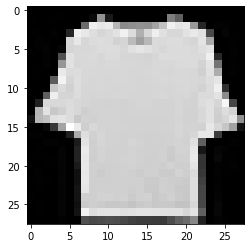

Digit obtained is 1
Img shape is torch.Size([1, 28, 28])


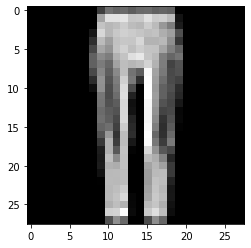

Digit obtained is 5
Img shape is torch.Size([1, 28, 28])


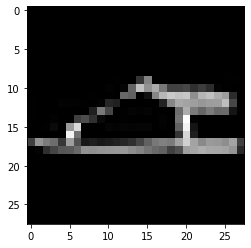

Digit obtained is 2
Img shape is torch.Size([1, 28, 28])


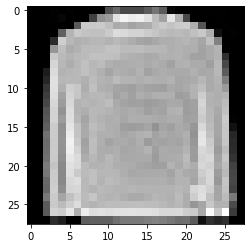

Digit obtained is 6
Img shape is torch.Size([1, 28, 28])


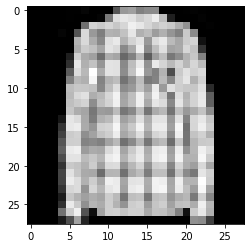

In [77]:
imgs_to_show = 5

for _ in range(imgs_to_show):
    images, digit_classes = next(iter(train_loader))
    img, digit_class = images[0], digit_classes[0]
    print(f"Digit obtained is {digit_class}")
    print(f"Img shape is {img.shape}")

    # Reshape and plot the img
    img = img.reshape((28, 28))
    show_img(img, color_format_range = (-1.0, 1.0))
    plt.show()

Now we can show more than one image at a time:

In [76]:
images, digit_classes = next(iter(train_loader))
images = [img.reshape((28, 28)) for img in images]
show_images(images, color_format_range = (-1.0, 1.0), columns = 4, figsize = (20, 20))

TypeError: ignored

Now lets see some statistics:

In [70]:
print(f"We have {len(train_dataset)} train samples")
print(f"We have {len(test_dataset)} test samples")

We have 60000 train samples
We have 10000 test samples


## Conclusions:

- We are working with $28 x 28 x 1$ images
- We have to work with ten classes
- 60k training samples and 10k test samples

# Defining the baseline model

In [71]:
class BaseLine(nn.Module):
    """
    Baseline model used to compare it with more advanced models
    Flatten the input and apply FC layers. Batch normalization enhanced a lot model performance (92% acc to 97% acc)
    """
    
    def __init__(self):
        # Init parent class
        super().__init__()
        
        # Architecture:
        self.fc1 = nn.Linear(28*28, 100)
        self.bn1 = nn.BatchNorm1d(100)
        
        self.fc2 = nn.Linear(100, 150)
        self.bn2 = nn.BatchNorm1d(150)

        self.fc3 = nn.Linear(150, 10)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Flatten the input
        x = torch.flatten(x, start_dim = 1)
        
        # First layer
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        # Second layer
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        
        # Output layer
        x = self.fc3(x)
        return x
        

# LuNet Model

In [72]:
class LuNet(nn.Module):
    """
    LuNet model adapted to 28x28x1 input images
    
    Based on the model presented in the paper "In defense of the triplet loss 
    for person re-identification"
    
    In order to make some experiments with this model
    
    Original architecture is quite similar to a common ResNet using bottleneck 
    building blocks with batch normalization. The real work happens in the 
    loss function and also the way triplets are chosen. So we are going to 
    stack some building blocks without max-pooling (28x28x1 is small enough)
    and apply that loss function and triplet selection policy
    
    
    """
    
    def __init__(self):          
        # Init parent class
        super().__init__()

        # ResNet Blocks
        self.block1 = BottleNeckBlock(
            input_channels = 1,
            output_channels = 8,
            kernel_size = 3,
            stride = 1,
            disable_identity = True,
        )
        
        self.block2 = BottleNeckBlock(
            input_channels = 8,
            output_channels = 8,
            kernel_size = 3,
            stride = 1,
            disable_identity = False,
        )
        
        self.block3 = BottleNeckBlock(
            input_channels = 8,
            output_channels = 16,
            kernel_size = 3,
            stride = 1,
            disable_identity = True,
        )
        
        self.block4 = BottleNeckBlock(
            input_channels = 16,
            output_channels = 16,
            kernel_size = 3,
            stride = 1,
            disable_identity = False,
        )
        
        # Fully connected layers
        # We end up with an embedding space of dimension 64
        self.fc1 = nn.Linear(12544, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ResNet blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        
        # Now fully-connected layers
        x = torch.flatten(x, start_dim = 1)
        
        x = self.fc1(x)
        # TODO -- enable this again
        #x = self.bn1(x)
        x = F.relu(x)        
        x = self.fc2(x)
        
        return x

# Custom Datasets

`TripletMarginLoss` requires three parameters: anchor, positive and negative. We can change the training loop for, given a batch of examples and their labels, calculate a triplet (we are going to end with batch hard triplets) and pass that to the loss func. Also we can make it generalized using lambda functions as parameters (more strategy pattern in training loop). 

Or we can do better and create a custom data loader that handles the creation of hard triplets, batches of hard triplets and left the training loop as it was. Fortunately, pytorch makes very easy and convinient to create custom data loaders. 

Inspired by [this notebook](https://www.kaggle.com/hirotaka0122/triplet-loss-with-pytorch#Define-class-MNIST). Our dataloader is slightly different (mainly the *batch hard triplet concept*)

## Random triplets

We well start by creating a custom data set that, given an anchor by its index, gets a random positive anda a random negative for that anchor. Its a good starting point but it's not enough, as said in the paper we're basing our work.

In [73]:
from torch.utils.data import Dataset

class MNIST_RANDOM_TRIPLET(Dataset):
    """
    Custom MNIST data loader that returns batch random triplets instead of input + label
    That means we select the anchor via the index, and then a positive and a negative is chosen randomly
    
    Under the hood, we are using pytorch mnist dataset, but creating the triplets
    """
    
    def __init__(self, train: bool = True, root: str = "./data", transform=None):
        """
        Initializes the dataset. Uses mnist dataset stored in pytorch
        
        Parameters:
        ============
        train: if we are loading the training set (True) or the test set (False)
        root: path where to save the dataset
        transform: transforms we want to apply to the images stored before returning them
        """
        
        self.train = train
        self.transform = transform
        
        # Our images storage 
        self.underlying_dataset = None
        if self.train is True:
            self.underlying_dataset = datasets.MNIST(root= root, train=True, download=True, transform=self.transform)
        else:
            self.underlying_dataset = datasets.MNIST(root= root, train=False, download=True, transform=self.transform)
            
        # We compute classes indixes here to save computation time in training loop
        self.indixes_of_classes = [self.__create_index_list(index) for index in range(0, 10)]
        self.indixes_of_classes = np.array(self.indixes_of_classes)
    
    def __len__(self):
        return len(self.underlying_dataset)
    
    def __getitem__(self, idx):
        """"
        Returns an item in the form of anchor, positive, negative image
        Anchor is given by the index, positive and negative chosen randomly
        
        Parameters:
        ============
        idx: index of the item we are looking for
        
        Returns:
        ========
        anchor: the idx-th image of the dataset
        positive: some image with the same idx of the image
        negative: some image with is no same idx of the image
        """
        
        # Convert tensor index into list index
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get the item from the dataset
        # Anchor is the image of given idx
        anchor, anchor_label = self.underlying_dataset[idx]
                
        # Now get some random positive fron the dataset
        positive_index = np.random.choice(self.indixes_of_classes[anchor_label][0])
        positive, _ = self.underlying_dataset[positive_index]
        
        # Now we get some random negative from the dataset
        negative_classes = np.delete(self.indixes_of_classes, [anchor_label])
        negative_class_indixes = np.random.choice(negative_classes)
        negative_index = np.random.choice(negative_class_indixes)
        negative, _ = self.underlying_dataset[negative_index]
   
        return anchor, positive, negative

    def __create_index_list(self, label: int) -> torch.Tensor:
        """
        Creates an array of indixes of the positions of certain label in the dataset
        For example: given class 0 returns np.array(3, 4, 9) because in these positions
        there are images matching that label
        """

        labels = self.underlying_dataset.targets
        indixes = torch.where(labels == label)
        indixes = indixes
        return indixes

Lets test this showing some images obtained through the custom Dataset

In [74]:
# Convert PIL images to tensor
# ALso normalize images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

# Create the dataset
dataset = MNIST_RANDOM_TRIPLET(train = True, transform = transform)

# Load some images
anchor, positive, negative = dataset[0]
anchor, positive, negative = anchor.reshape(28,28), positive.reshape(28,28), negative.reshape(28,28)
show_images([anchor, positive, negative], color_format_range = (-1.0, 1.0))

ValueError: ignored

And now I override classic dataloader with our custom dataset:

In [ ]:
# Convert PIL images to tensor
# ALso normalize images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

# Create the dataset
training_set = MNIST_RANDOM_TRIPLET(train = True, transform = transform)
testing_set = MNIST_RANDOM_TRIPLET(train = False, transform = transform)


# Data loaders for accessing the data
batch_size = 32
num_workers = 2
train_loader = torch.utils.data.DataLoader(
    training_set, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory = True,
)
test_loader = torch.utils.data.DataLoader(testing_set, batch_size = batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)


# Batch Hard Triplets

This time we are going to implement a dataset for mining batch hard triplets. In order to implement this, we have to:

- Randomly sample P classes
- Randomly sample K images for each P classes
- For each image, compute loss using hardest positive and hardest negative

So, when accessing the dataset using index i-th, we are going to generate a PK batch. So the dataloader has to use batch size 1, because we're doing the batch working directly through the dataset (I tried to do this trought the dataloader but failed to do so)

Also, the len of the dataset is going to set by the user of the dataset, because we're randomly sampling batches, thus we can set `__len__`as we want

In [ ]:
from torch.utils.data import Dataset

class MNIST_HARDBATCH_TRIPLET(Dataset):
    """
    Custom MNIST data loader that returns batch hard triplets instead of input + label
    That means we are sampling P classes from the dataset. For each class we're sampling
    K images. Therefore, we end with PK image. 
    
    For each image in the PK class, we want to compute the triplet loss using the hardest
    positive and the hardest negative. But this has to be handled in the training loop
    
    This dataset implements some kind of batching. Thus, the dataloader used with this
    dataset has to use batch_size = 1
    
    Under the hood, we are using pytorch mnist dataset, but managing the triplets
    """
    
    def __init__(self, train: bool = True, root: str = "./data", transform=None, num_classes: int = 4, images_per_class: int = 10, custom_len: int = 32):
        """
        Initializes the dataset. Uses mnist dataset stored in pytorch
        
        Parameters:
        ============
        train: if we are loading the training set (True) or the test set (False)
        root: path where to save the dataset
        transform: transforms we want to apply to the images stored before returning them
        num_classes: number of classes sampled at each batch
        images_per_class: number of images sampled for each sampled class
        custom_len: custom len, we are not using the original dataset len because we're randomly sampling images
                    from the dataset, so any len can be specified. A good idea can be:
                        custom_len = len(dataset) / (PK)
        """
        
        self.train = train
        self.transform = transform
        self.num_classes = num_classes
        self.images_per_class = images_per_class
        self.custom_len = custom_len
        
        # Our images storage 
        self.underlying_dataset = None
        if self.train is True:
            self.underlying_dataset = datasets.MNIST(root= root, train=True, download=True, transform=self.transform)
        else:
            self.underlying_dataset = datasets.MNIST(root= root, train=False, download=True, transform=self.transform)
            
        # We compute classes indixes here to save computation time in training loop
        self.indixes_of_classes = [self.__create_index_list(index) for index in range(0, 10)]
        self.indixes_of_classes = np.array(self.indixes_of_classes)
    
    def __len__(self):
        # We return the custom len that the user of this dataset specifies
        return self.custom_len
    
    def __getitem__(self, idx):
        """"
        Returns a batch consisting of PK images, as describe in the class docs
                
        Parameters:
        ============
        idx: index of the item we are looking for
             In this case, this index is useless
        
        Returns:
        ========
        training_batch: dict having P keys (class labels) and keys of K images for each class
        """
        
        # TODO -- not correct: Convert tensor index into list index
        # Check if we are using batch size greater than 0
        if torch.is_tensor(idx):
            #idx = idx.tolist()
            raise Exception("MNIST_HARDBATCH_TRIPLET don't support batch size greater than 1")

                
        # Dict we are going to return
        training_batch = dict()
        
        # Select P different random classes
        classes = [x for x in range(0, 10)]
        classes = np.random.choice(classes, size = self.num_classes, replace = False)
        
        # Select K randon images for each class
        for curr_class in classes:
            # Select random indixes of images belonging to this class
            curr_images_idx = self.indixes_of_classes[curr_class][0]
            curr_images = np.random.choice(curr_images_idx, size = self.images_per_class, replace = False)
            
            # Convert random indixes to their correspondent images
            curr_images = [self.underlying_dataset[idx] for idx in curr_images]
            
            # We are using underlying dataset for getting images, so we get batches
            # of size 1 when querying for images. Also reshape to have images of
            # shape 28x28
            curr_images = [img[0] for img in curr_images]
            curr_images = [img.reshape(28, 28) for img in curr_images]
            
            # Set this to our dict
            training_batch[curr_class] = curr_images
        
        return training_batch

    def __create_index_list(self, label: int) -> torch.Tensor:
        """
        Creates an array of indixes of the positions of certain label in the dataset
        For example: given class 0 returns np.array(3, 4, 9) because in these positions
        there are images matching that label
        """

        labels = self.underlying_dataset.targets
        indixes = torch.where(labels == label)
        indixes = indixes
        return indixes
    
    def display_batch(batch: dict):
        """Gets a dict created by Self.__getitem__, and for each random sampled class,
        displays some random images corresponding to that class"""
        # Show some images from the batch
        # Convert dict of images to single-line list
        images = []
        for key in batch:
            curr_images = batch[key]
            curr_images = curr_images[:5]
            
            # Just in case, it should not happen
            curr_images = [img.reshape(28, 28) for img in curr_images]
            
            # Append to the image list
            images = images + curr_images

        show_images(images, color_format_range = (-1, 1), columns = 5)

Lets see how it works the dataset works. For this, we create a random batch from the dataset, and show for each random sampled class, some images sampled for that class: 

In [ ]:
# First, generate the dataset
training_set = MNIST_HARDBATCH_TRIPLET(
    train = True, 
    root = "./data",
    transform=transform,
    num_classes = 4, 
    images_per_class = 10,
    custom_len = 32
)

# Now, get a batch from the dataset
batch = training_set[0]
MNIST_HARDBATCH_TRIPLET.display_batch(batch)

Now we are going to define datasets and dataloaders for training and testing:

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

# Loading the data
# TODO -- apply transfors to normalize and do data augmentation
# TODO -- split train loader for having training / validation set
train_dataset = MNIST_HARDBATCH_TRIPLET(    
    train = True, 
    root = "./data",
    transform=transform,
    num_classes = 4, 
    images_per_class = 10,
    custom_len = 32
)
test_dataset = MNIST_HARDBATCH_TRIPLET(   
    train = False, 
    root = "./data",
    transform=transform,
    num_classes = 4, 
    images_per_class = 10,
    custom_len = 32
)

# Data loaders for accessing the data
batch_size = 1 # This time we have to use batch size of 1
num_workers = 2
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory = True,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = True, 
    num_workers = num_workers, 
    pin_memory = True
)

Check if dataloaders work well, because we're handling batches in non-pytorch way:

In [ ]:
for batch in test_loader:    
    MNIST_HARDBATCH_TRIPLET.display_batch(batch)
    
    # Only show one iteration of the dataloader
    break

# Training the model

In [ ]:
# Set the training parameters
parameters = dict()
parameters["lr"] = 0.001
parameters["momentum"] = 0.9
parameters["criterion"] = triplet_loss_batch_hard
parameters["epochs"] = 10

# We save the model in different paths wether we're running
# local or in cloud
save_model_path = None
if running_env == "local": save_model_path = "./saved_models"
if running_env == "cloud": save_model_path = "drive/MyDrive/ml/Modelos/MNIST-ReID/saved_models"

# Network we are going to train
net = LuNet()

# Specifying the trainning logger
logger = TripletLogger(
    iterations = 200 * batch_size, # TODO -- document why multiplying batch_size 
    loss_func = triplet_loss_batch_hard, 
    net = net,
    training_perc = 0.2, 
    validation_perc = 1.0
)

# If running in cloud, show tensorboard inline
if running_env == "cloud":
    %load_ext tensorboard
    %tensorboard --logdir runs

# Train process
core.batch_hard_train(
    net, 
    save_model_path, 
    parameters, 
    train_loader = train_loader, 
    validation_loader = test_loader, # TODO -- we are using test dataset as validation dataset 
    name = "LuNet", 
    logger = logger,
    snapshot_iterations = 10_000 
)

# Close the logger when we are done with the training
logger.close()

# Evaluating the model

# Some conclusions and thoughts

- Base model with no hyperparameter tuning, and just three fc layers with batch normalization reaches ~97% acc on test set
    - Trained with 0.001 lr
    - Trained with 0.01 lr converges much faster and also reaches 97% acc on test set
- Baseline LuNet model with no hyperparameter tuning also reaches ~96% acc
    - Baseline Lunet means we are using the LuNet architecture but cross entropy loss and classic training loop 
    - For baseline, the size of output layer has to be 10, in our actual model we use higher value for specifying embedding space dimension